# **Capstone DATA 606 Project**: NYC 311 service requests 
## By: Megan Ross


# Introduction



**The dataset: NYC Open Data 311 Service Requests**

*   311 is a non-emergency phone number that allows callers to report problems, access municipal services, and request information
*   Dataset is automatically updated daily, was made public in Oct 2011
*   Each row is a 311-service request
*   Individuals can call these requests in or log them online/via mobile devices


*   Link: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9






Our goal using the NYC 311 dataset was to see if we could create a model that could predict response times for various calls and complaints. To do this, we have to create columns that represent the response time (date created vs. date closed). Othre key feautures included in our analysis include borough, complaint type, and responding agency. Based on the size of the dataset, we decided to only include records from 2020 with a status=closed so we can create our response time column.  

## Import Packages

In [1]:
!pip install sodapy # sodapy- python socrata client 
!pip install pmdarima #pmd arima 

ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#pmd'


# Load Data 

*   Load data from Socrata (Socrata Open Data (SODA)) API partners with NYC Open Data to host City data
*   Source: https://holowczak.com/getting-started-with-nyc-opendata-and-the-socrata-api/5/

### Data critera: 

*   Selected data that was created in 2020 and the ticket status is closed
*   The limit in the below is how many recent rows do you want






In [3]:
%%time

from sodapy import Socrata
import pandas as pd

client = Socrata("data.cityofnewyork.us", None)
# Set the timeout in seconds
client.timeout = 360
# Limit = how many rows should we pull? (Starts from most recent and works back)
results = client.get("erm2-nwe9", 
                     select="created_date, closed_date, agency, complaint_type, status, borough,unique_key ",
                     order="created_date DESC", where="created_date > '2020' AND created_date < '2021' AND status = 'Closed'",
                     limit = 3000000)
df1 = pd.DataFrame.from_records(results)

Wall time: 1min 23s


In [4]:
# How many rows of data did we import?
print(df1.shape)

(2487209, 7)


Create a new column date_diff where we calculate the time between when the complaint was entered and when it was closed. We looked at date_diff in days, hours, and seconds. 


In [7]:
%%time
# Create column with the difference of the dates a ticket was closed and open.
from datetime import timedelta
import numpy as np

df1[['created_date', 'closed_date']] = df1[['created_date', 'closed_date']].apply(pd.to_datetime)
df1["hour"]=pd.DatetimeIndex(df1["created_date"]).hour
df1['date_diff'] = df1['closed_date'] - df1['created_date']
df1['date_diff_sec'] = df1['date_diff'].dt.total_seconds()
df1["date_diff_hours"] = round(df1["date_diff_sec"]/3600, 1)

# Taking a look at the data
df1.sample(10)

Wall time: 807 ms


,created_date,closed_date,agency,complaint_type,status,borough,unique_key,hour,date_diff,date_diff_sec,date_diff_hours
942506,2020-08-23 01:21:00,2020-08-23 10:05:00,DEP,Water System,Closed,MANHATTAN,47333510,1,0 days 08:44:00,31440.0,8.7
229534,2020-11-25 13:38:58,2020-11-25 14:15:26,NYPD,Blocked Driveway,Closed,QUEENS,48249083,13,0 days 00:36:28,2188.0,0.6
1469715,2020-06-27 10:56:44,2020-06-27 10:58:51,NYPD,Non-Emergency Police Matter,Closed,QUEENS,46660937,10,0 days 00:02:07,127.0,0.0
296613,2020-11-15 21:09:03,2020-11-26 10:45:52,HPD,WATER LEAK,Closed,STATEN ISLAND,48160856,21,10 days 13:36:49,913009.0,253.6
1993279,2020-04-09 18:14:30,2020-04-09 19:14:03,NYPD,Non-Emergency Police Matter,Closed,BRONX,45972435,18,0 days 00:59:33,3573.0,1.0
209113,2020-11-29 04:09:15,2020-11-29 04:28:38,NYPD,Noise - Residential,Closed,BROOKLYN,48279646,4,0 days 00:19:23,1163.0,0.3
346133,2020-11-08 06:07:24,2020-11-08 07:31:48,NYPD,Illegal Fireworks,Closed,QUEENS,48102322,6,0 days 01:24:24,5064.0,1.4
1456945,2020-06-28 11:25:19,2020-07-06 11:31:36,DOHMH,Indoor Air Quality,Closed,MANHATTAN,46672500,11,8 days 00:06:17,691577.0,192.1
2325249,2020-02-01 06:48:34,2020-02-01 09:57:03,NYPD,Noise - Residential,Closed,BROOKLYN,45524572,6,0 days 03:08:29,11309.0,3.1
433143,2020-10-27 02:00:50,2020-10-31 02:04:15,HPD,HEAT/HOT WATER,Closed,BROOKLYN,47991636,2,4 days 00:03:25,345805.0,96.1


Lets create a column of the month for later

In [9]:
%%time
# Create month column 
df1["month"] = pd.DatetimeIndex(df1["created_date"]).month
df1.head()

Wall time: 248 ms


,created_date,closed_date,agency,complaint_type,status,borough,unique_key,hour,date_diff,date_diff_sec,date_diff_hours,month
0,2020-12-31 23:59:55,2021-01-01 01:07:04,NYPD,Noise - Vehicle,Closed,BRONX,48538697,23,01:07:09,4029.0,1.1,12
1,2020-12-31 23:59:28,2021-01-01 00:29:13,NYPD,Homeless Street Condition,Closed,MANHATTAN,48540181,23,00:29:45,1785.0,0.5,12
2,2020-12-31 23:59:28,2021-01-01 01:33:12,NYPD,Noise - Residential,Closed,MANHATTAN,48536596,23,01:33:44,5624.0,1.6,12
3,2020-12-31 23:58:55,2021-01-01 00:24:54,NYPD,Noise - Residential,Closed,BRONX,48536500,23,00:25:59,1559.0,0.4,12
4,2020-12-31 23:58:49,2021-01-01 01:52:20,NYPD,Blocked Driveway,Closed,BROOKLYN,48537397,23,01:53:31,6811.0,1.9,12


In [10]:
%%time
# Shape with new columns added
print(df1.shape)

(2487209, 12)
Wall time: 1.04 ms


In [44]:
print(df1. columns)

Index(['created_date', 'closed_date', 'agency', 'complaint_type', 'status',
       'borough', 'unique_key', 'hour', 'date_diff', 'date_diff_sec',
       'date_diff_hours', 'month', 'created_dd_mm_yyy'],
      dtype='object')


# Data Cleaning
There are many complaint types but some of them are not intelligible, to rectify this we looked at how many times each complaint was logged

In [11]:
%%time
# Get unique complaint types
df_unique = df1['complaint_type'].value_counts()
# Look at count of unique complaint types
print(df_unique.shape) 

(173,)
Wall time: 634 ms


In [12]:
%%time
# Drop complaint types with a value count of less than or equal to 2 (messy data). These are the complaint types that have hardly been used. 
value_counts = df1['complaint_type'].value_counts()
to_remove = value_counts[value_counts <= 2].index 

df1.drop(df1[df1['complaint_type'].isin(to_remove)].index, inplace = True)

df_unique = df1['complaint_type'].value_counts()
print(df_unique.shape)

(164,)
Wall time: 1.83 s


In [13]:
%%time
# Sum NaN per column to see what can cause issues in the analysis
df1.isna().sum()

Wall time: 1.12 s


created_date           0
closed_date            2
agency                 0
complaint_type         0
status                 0
borough            24906
unique_key             0
hour                   0
date_diff              2
date_diff_sec          2
date_diff_hours        2
month                  0
dtype: int64

In [14]:
#drop the nulls since it will not drop a significant amount of data
df1 = df1.dropna()

# Visualizations 


Taking a look at the count of calls over the entire year 2020

Wall time: 2.15 s


Text(0.5, 0, 'Date')

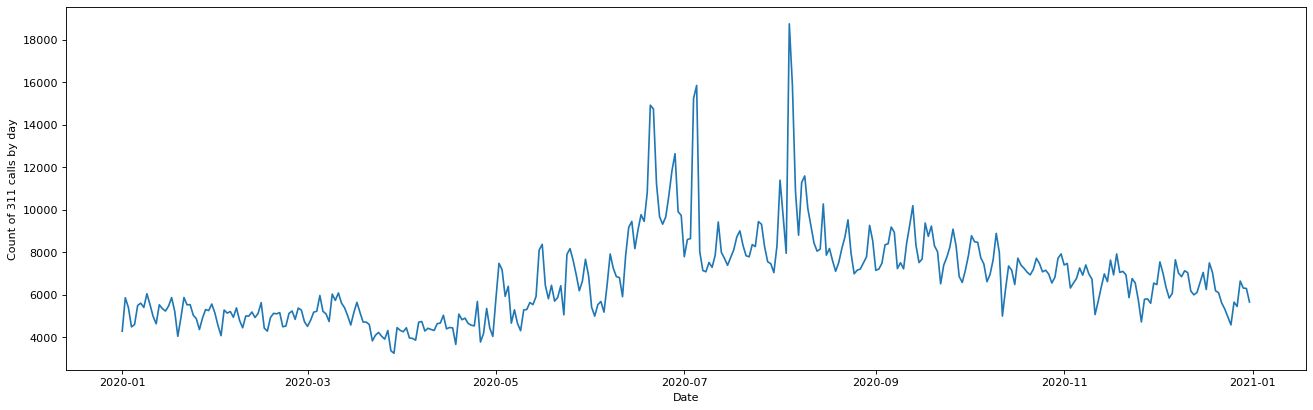

In [15]:
%%time
#Number of 311 calls made per day in 2020.
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)
dfLine = df1['month'].groupby(df1.created_date.dt.date).count()

ax = dfLine.plot.line()
ax.set_ylabel("Count of 311 calls by day")
ax.set_xlabel("Date")

 We see a big spike in 1 day, what caused this?
> What are the top 5 dates for most complaints?




2020-08-04    18747
2020-08-05    15867
2020-07-05    15846
2020-07-04    15235
2020-06-20    14917
Name: created_dd_mm_yyy, dtype: int64
Wall time: 23.6 s


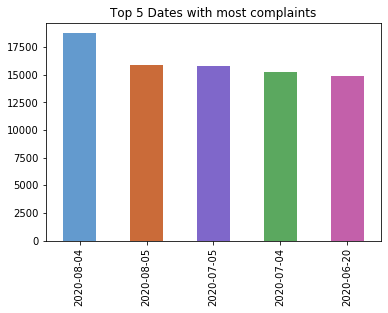

In [18]:
%%time
colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f','#cc566a']
dfLine2 = dfLine.reset_index()
df1["created_dd_mm_yyy"]=df1.created_date.map(lambda x: x.strftime('%Y-%m-%d'))
print(df1.created_dd_mm_yyy.value_counts().nlargest(5))
df1.created_dd_mm_yyy.value_counts().nlargest(5).plot(kind = "bar", x= "Date", y= "Number of Complaints", title= "Top 5 Dates with most complaints", color= colors)


August 4th was the day New York was hit with tropical storm Isaias: 
https://www.ny1.com/nyc/all-boroughs/weather/2020/08/04/isaias-new-york-city-august-4

4th of July was also up there for more complaints



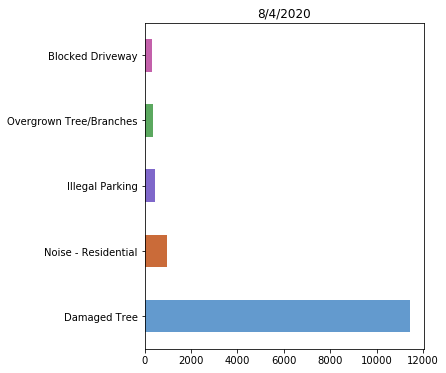

In [19]:
# what were the top 5 complaints on 8/4?
from matplotlib.pyplot import figure
colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f']
#Storm
df1.complaint_type.where(df1["created_dd_mm_yyy"] == "2020-08-04").value_counts().nlargest(5).plot(kind='barh', title="8/4/2020", color=colors, figsize=(5,6))

The most common complaint type from 8/4 was "damaged trees" 

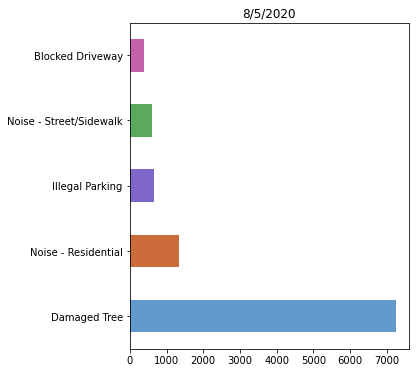

In [14]:
# what were the top 5 complaints on 8/5?
from matplotlib.pyplot import figure
colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f']
#Storm
df1.complaint_type.where(df1["created_dd_mm_yyy"] == "2020-08-05").value_counts().nlargest(5).plot(kind='barh', title="8/5/2020", color=colors, figsize=(5,6))

The most common complaint the next day (8/5)  was still Damaged tree 



Let's look at what time of day these calls were being called in

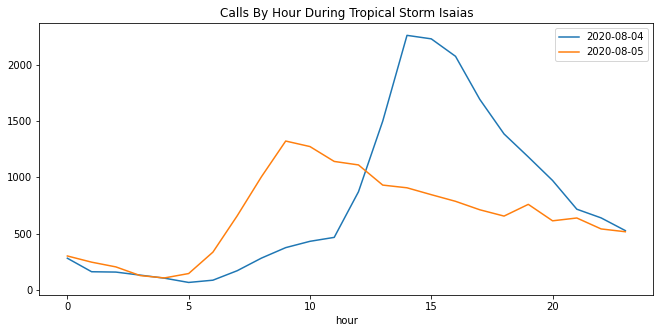

In [15]:
calls_over_time = df1.pivot_table(index="created_dd_mm_yyy", columns ="hour", values = "unique_key", aggfunc = "count")
calls_over_time.loc["2020-08-04"].plot(kind="line",x="hour", y="Number of calls",legend=True, figsize=(11,7)) 
calls_over_time.loc["2020-08-05"].plot(kind="line",x="hour", y="Number of calls",title="Calls By Hour During Tropical Storm Isaias",legend=True , figsize=(11,5)) 

You can see what time the storm hit on the 4th and what time people woke up on the 5th

Next, we will take a look at 7/4 and 7/5.

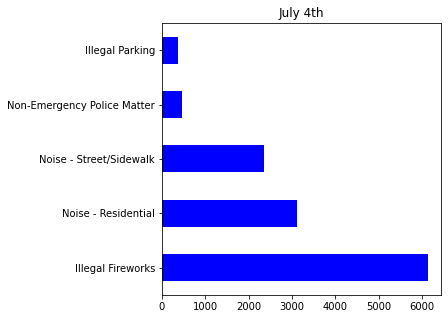

In [16]:
#4th of July
df1.complaint_type.where(df1["created_dd_mm_yyy"] == "2020-07-04").value_counts().nlargest(5).plot(kind='barh', title="July 4th", color="#0000FF",figsize=(5,5)) 


Fireworks on the 4th of July are typical, so this complaint makes sense. 

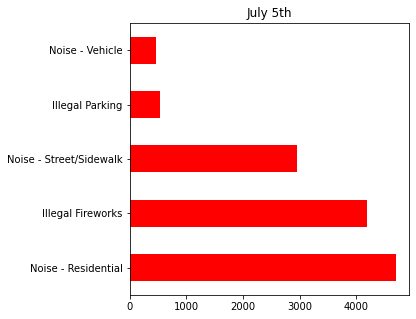

In [17]:

df1.complaint_type.where(df1["created_dd_mm_yyy"] == "2020-07-05").value_counts().nlargest(5).plot(kind='barh', title="July 5th", color="#FF0000",figsize=(5,5)) 


Fourth of July parties that ran long (past-midnight)  would have been counted as occuring on 7/5


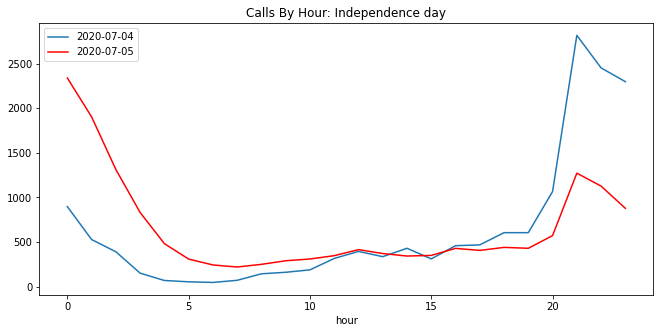

In [18]:
colors = "#FF0000","#0000FF"
calls_over_time.loc["2020-07-04"].plot(kind="line",x="hour", y="Number of calls",legend=True, figsize=(11,7)) 
calls_over_time.loc["2020-07-05"].plot(kind="line",x="hour", y="Number of calls",title="Calls By Hour: Independence day",legend=True ,color=colors, figsize=(11,5)) 

Most calls during the night, opposite of what we saw during the storms. Fourth of July celebrations would typically start at night and continue into the early morning which is in line with the graph. 

As we can see from the above graph, calls spiked from the evening of 7/4 into the early morning of 7/5

The last day we will look at is 6/20

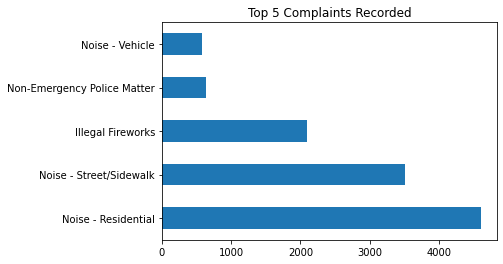

In [19]:
#Night after JuneTeenth, and Firework controversy
#https://gothamist.com/news/illegal-fireworks-soar-nyc-complaints-2020
df1.complaint_type.where(df1["created_dd_mm_yyy"] == "2020-06-20").value_counts().nlargest(5).plot(kind='barh', title="Top 5 Complaints Recorded")

6/20 was the day after Juneteeth, which was officially made a holiday in 2020. Celebratory events were planned for the event along with Black Lives Matter protests. 

We examined the pattern of these calls by hour. 

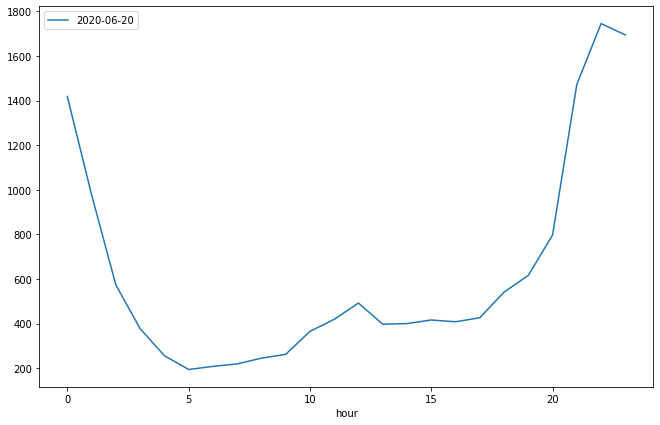

In [20]:
colors = "#FF0000","#0000FF"
calls_over_time.loc["2020-06-20"].plot(kind="line",x="hour", y="Number of calls",legend=True, figsize=(11,7)) 

These called peaked during the late night and early morning which is indiciative of night time complaints. 

Now, we will look at the most frequent complaint types. 

Wall time: 636 ms


Text(0, 0.5, 'Complaint Type')

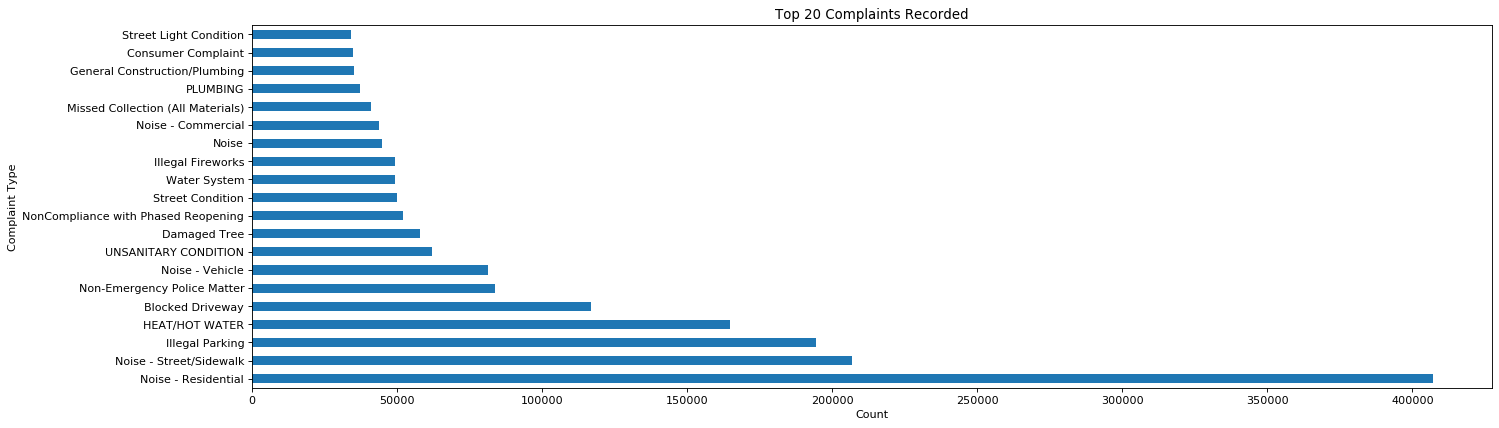

In [20]:
%%time
# Graph to see top complaint types
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)
ax = df1.complaint_type.value_counts().nlargest(20).plot(kind='barh', title="Top 20 Complaints Recorded")
ax.set_xlabel("Count")
ax.set_ylabel("Complaint Type")

The most common complaint types are for noise and illegal parking. Reports of these types of infractions may have risen due to the pandemic and the fact that more people were at home during business hours leading to more awareness of noise. 

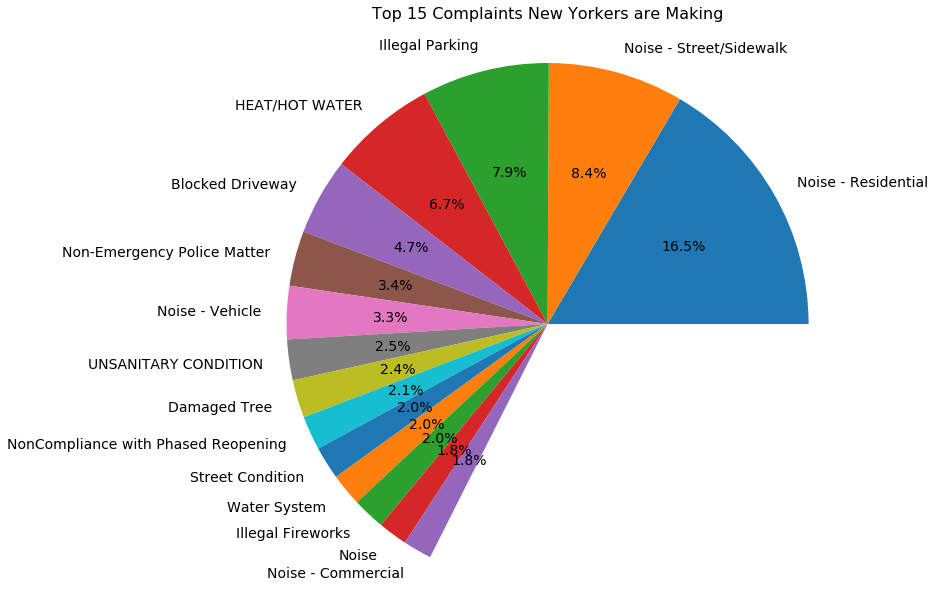

In [42]:
#Figure showing the overall percents of the top 15 complaints 
import matplotlib.pyplot as plt
# Find percent of each complaint type
df_complaint = df1['complaint_type'].value_counts()[:15].sort_values(ascending=False) / len(df1)
sizes = df_complaint.values.tolist()
labels = df_complaint.index.values.tolist()

# Pie chart for complaint type
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False,textprops={'fontsize': 14})
ax1.axis('equal')
plt.title("Top 15 Complaints New Yorkers are Making", fontdict={'fontsize':16}, loc="center", pad=20)
plt.show()

The below visual is the same idea as above just visualized as a word cloud


In [38]:
# WordCloud libraries
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

# Group by complaint_type and count the frequency of unique keys
total = df1.groupby(["complaint_type"],as_index=False).agg({"unique_key": "count"})

# Dataframe for WordCloud, could change this to any number
top50 = total.nlargest(100,"unique_key")
top50

,complaint_type,unique_key
98,Noise - Residential,407045
99,Noise - Street/Sidewalk,206709
73,Illegal Parking,194275
59,HEAT/HOT WATER,164597
11,Blocked Driveway,116751
...,...,...
96,Noise - House of Worship,620
104,OUTSIDE BUILDING,516
77,Industrial Waste,480
79,Investigations and Discipline (IAD),417


Top 50 Complaints


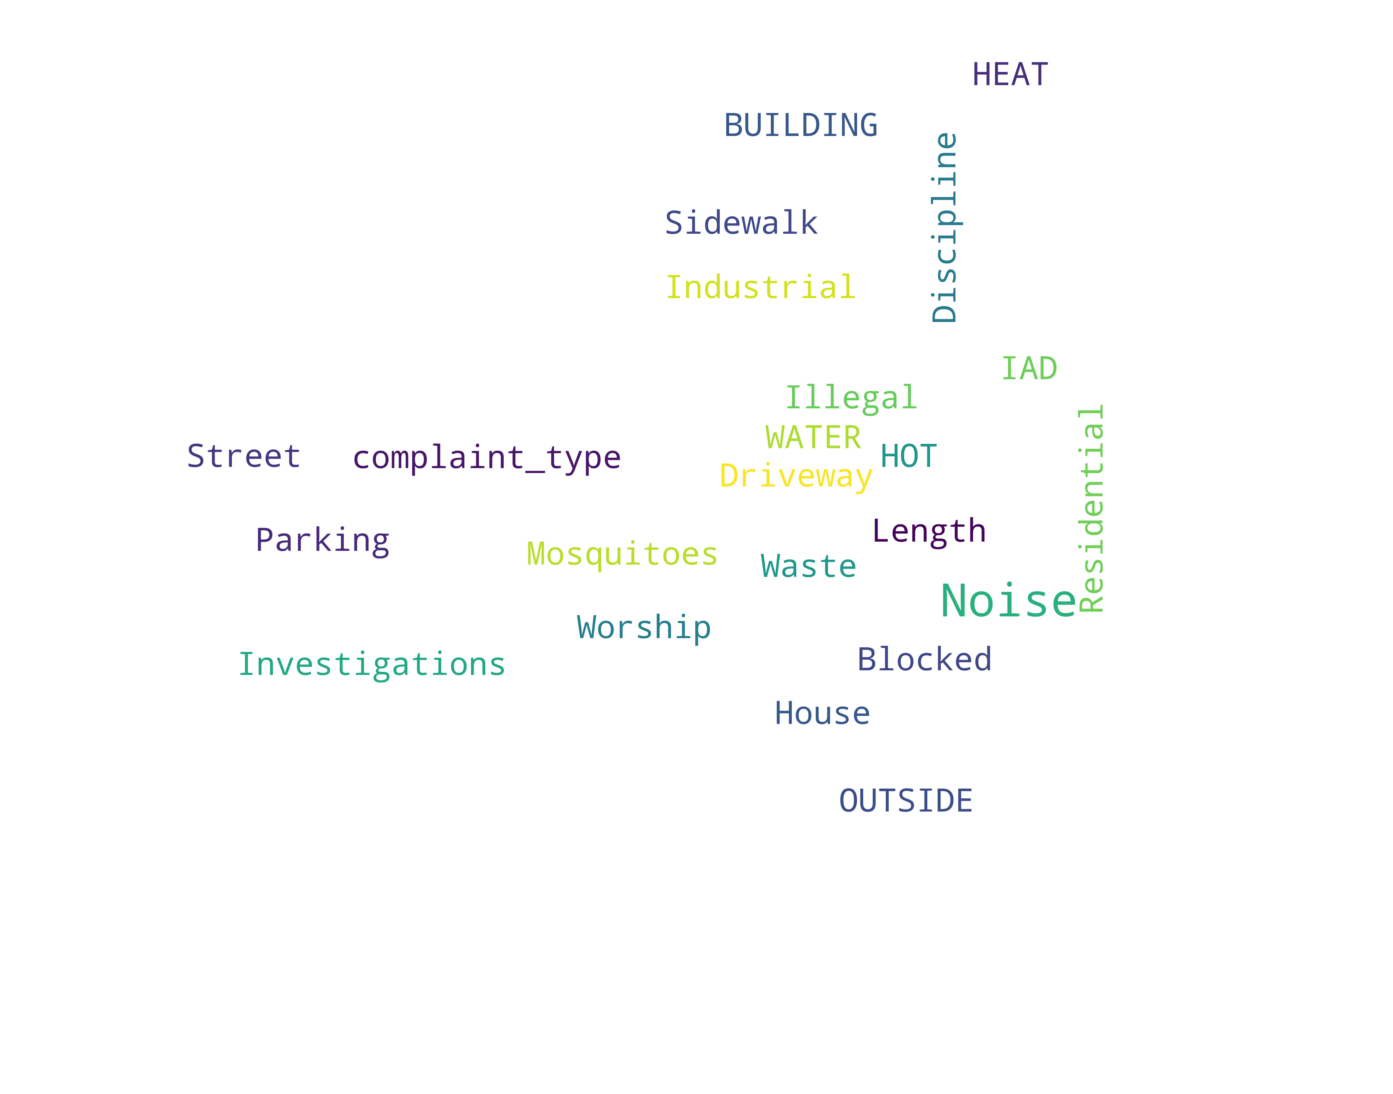

In [41]:
# Select text for WordCloud
text = top50["complaint_type"]
exclude = ["type", "dtype","Name","object"]
stopwords = STOPWORDS.update(exclude)    # STOPWORDS is a of type Set     

mask = np.array(Image.open('nyc6.jpg'))
wc = WordCloud(scale = 15, mask=mask,max_font_size=10,background_color = 'white',stopwords = stopwords)
wc.generate(str(text))

#S how figure
fig = plt.figure(figsize = (25,15))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
print("Top 50 Complaints")
plt.show()

Looking at the data by borough:




CPU times: user 520 ms, sys: 9.89 ms, total: 530 ms
Wall time: 541 ms


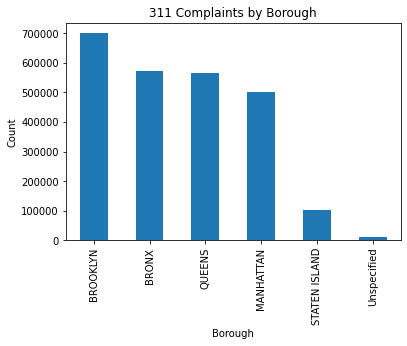

In [ ]:
%%time
# Graph to see a value count by borough
ax1 = df1.borough.value_counts().plot(kind='bar', title= "311 Complaints by Borough")
ax1.set_xlabel("Borough")
ax1.set_ylabel("Count")

Brooklyn has the most complaints of any borough with an additional 150,000 complaints logged compared to the Bronx.

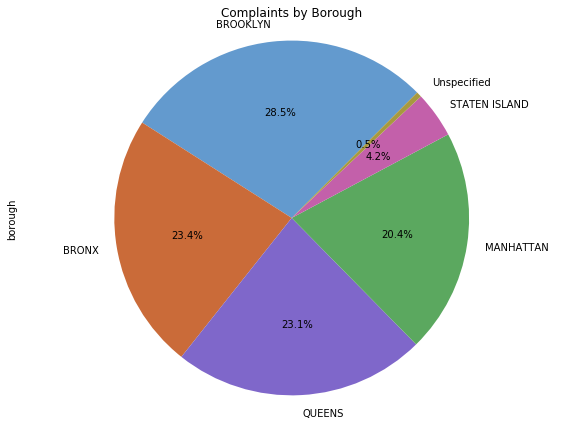

Wall time: 757 ms


In [43]:
%%time
# Same idea as above just visualized differently
import matplotlib as mpl
from matplotlib import pyplot as plt

colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f','#cc566a']
df1['borough'].value_counts().plot(kind='pie',autopct='%1.1f%%',
                        startangle=45, shadow=False, colors = colors,
                        figsize = (8,6))
plt.axis('equal')
plt.title('Complaints by Borough')
plt.tight_layout()
plt.show()

When is each agency receving the most calls during the day?

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Responding Agency by Hour')]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


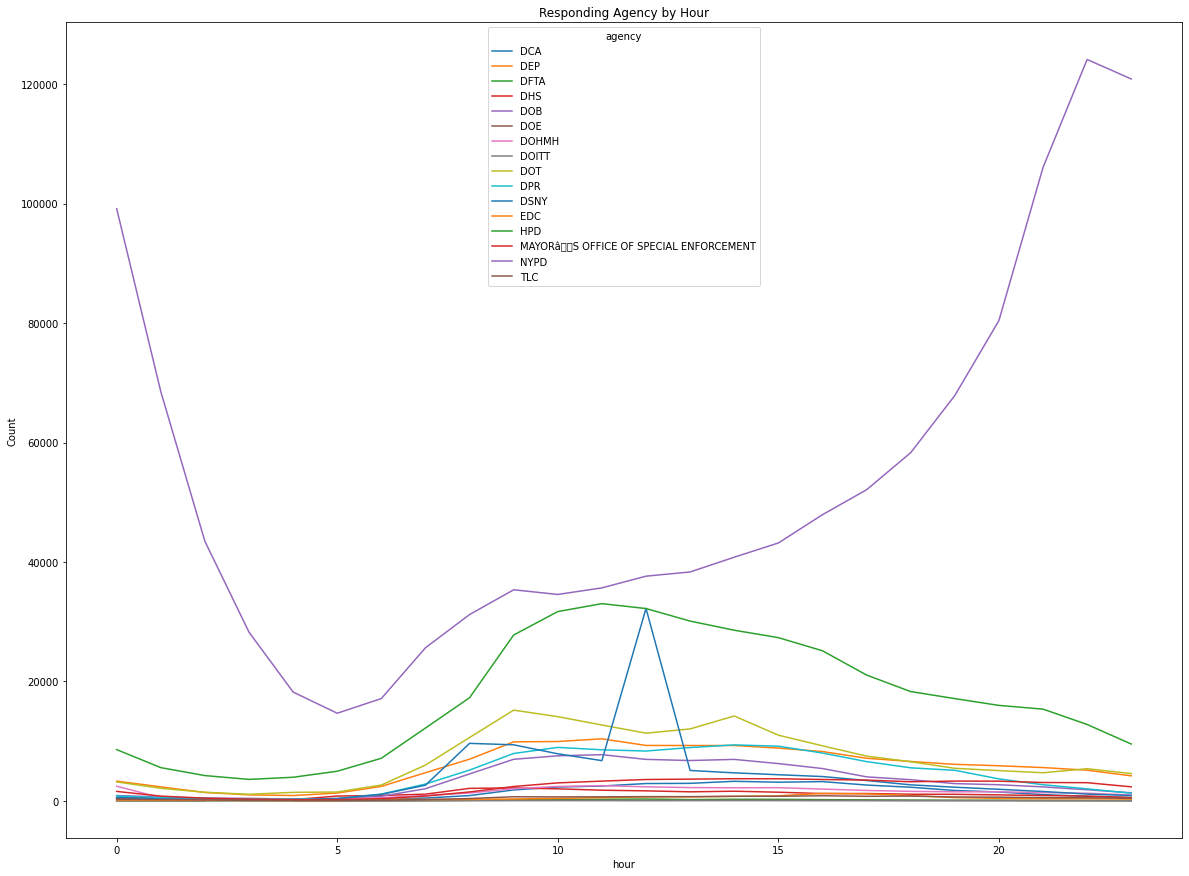

In [ ]:
# Examine when each agency is busy during the day
agency = df1.pivot_table(index="hour", columns = "agency", values = "unique_key", aggfunc = "count")
agency.plot(kind="line", figsize=(20,15)).set(title="Responding Agency by Hour", ylabel = "Count")

As you can see from the above, NYPD issues spike at night. Other agencies that are likely open during normal business hours, see spikes during the day, particuraly at lunch when people may have time to report issues. 

In [ ]:
%%time
# Create a df that groups the complaints by month to view MoM trends
df3 = df1.groupby(by=["complaint_type", "month"]).agg({"count"}).reset_index()
df3.sample(5)

CPU times: user 2.31 s, sys: 13.1 ms, total: 2.33 s
Wall time: 2.32 s


CPU times: user 43.4 ms, sys: 0 ns, total: 43.4 ms
Wall time: 43.7 ms


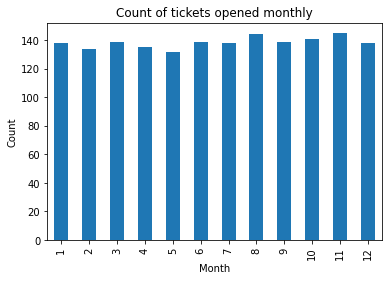

In [ ]:
%%time
# Graph to see number of tickets opened each month
df_ctype_by_month = df3.month.value_counts()
df_ctype_by_month.head(12)

ax2=df3['month'].value_counts().sort_index().plot(kind='bar', title="Count of tickets opened monthly")
ax2.set_xlabel("Month")
ax2.set_ylabel("Count")

This shows the number of complaints by month. 

In [ ]:
%%time
# Top 5 most popular complaints in each borough
df_count = df1[['borough', 'complaint_type', "unique_key"]].groupby(['borough', 'complaint_type']).count().reset_index()
df_count.columns = ["borough", "complaint_type", "complaints"]
df_count2 = df_count.sort_values(by=["borough", "complaints"], ascending=[True, False])
df_count3 = df_count2.groupby(["borough"]).head(5)
df_count3

CPU times: user 1.6 s, sys: 13.7 ms, total: 1.62 s
Wall time: 1.61 s


Next, we looked at the top 5 complaints by borough

CPU times: user 194 ms, sys: 6.15 ms, total: 200 ms
Wall time: 195 ms


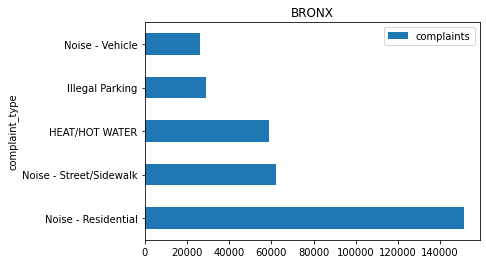

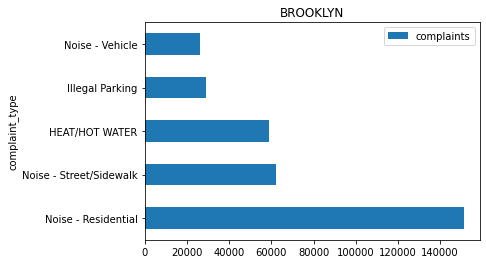

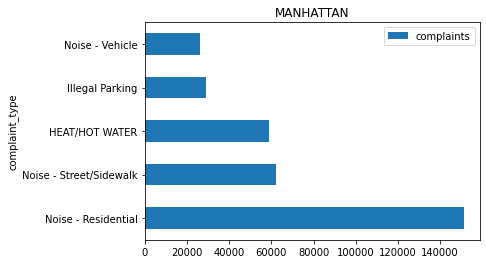

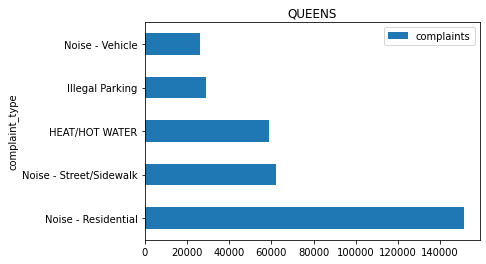

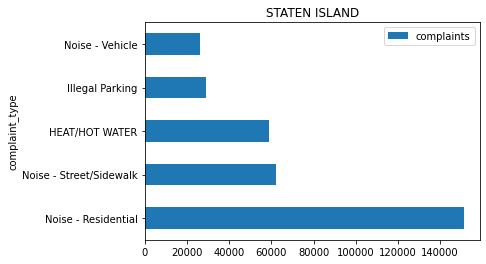

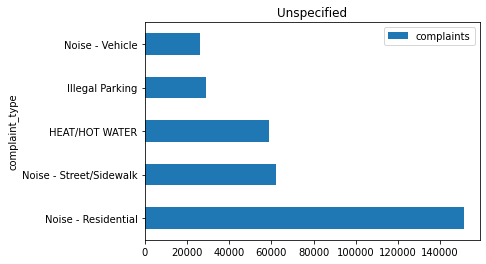

In [ ]:
%%time
# View the above in graph form
boroughs = df_count3.groupby(["borough"])
for b,group in boroughs:
    df_count3.head(5).plot(kind = "barh", x= "complaint_type", title=b)

All 5 bouroughs and unspecificed calls had the same top 5 complaints in the same order: Residential noise, Street/sidewalk noise, Heat/hot water, illegal parking, and vehicle noise.

Look at the top 10 complaints designated by borough 
> i.e. Which complaints by borough were most frequently called in 

CPU times: user 4.15 s, sys: 23.4 ms, total: 4.17 s
Wall time: 4.14 s


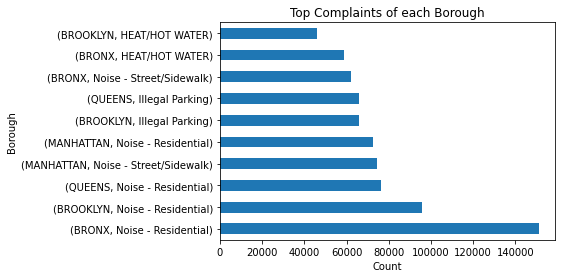

In [ ]:
%%time
# Graph to see overall top compaints by borough
df4 = df1['complaint_type'].groupby(df1['borough']).value_counts()
df4.groupby(level=[0,1]).nlargest(10)
ax3 = df1.groupby('borough')['complaint_type'].value_counts().nlargest(10).plot(kind='barh', title="Top Complaints of each Borough")
ax3.set_xlabel("Count")
ax3.set_ylabel("Borough")

We can see that the most common complaint was residential noise complaints in the Bronx which is extremely large relative to other top complaints and the overall number of complaints orginiating in the Bronx. 

In [ ]:
%%time
# Check to see if each complaint type is unique to one agency, i.e. does only one agency respond to Illegal parking?
df_res = df1[["complaint_type", "agency", "unique_key"]]
df_res.head()
df_res = df_res[df_res ["complaint_type"]=="Illegal Parking"]
df_res = df_res.groupby(by=["agency"]).agg({"count"}).reset_index()
df_res.head()

CPU times: user 792 ms, sys: 5.84 ms, total: 798 ms
Wall time: 794 ms


We used the above code to see if multiple agencies tend to respond to the same complaint type or if each complaint type seems to pair with an agency. For the most part (a few exceptions) one specific agency will respond to a complaint type. For example, only the NYPD responds to Illegal Parking. We needed to confirm this before deciding what to use to test our model. 

In [ ]:
%%time
# Find the average time to close complaints by borough 
df_datediff = df1[[ "borough", "unique_key", "date_diff_hours"]]
df_datediff.head()
df_datediff = df_datediff.groupby(by=(["borough"])).agg({"mean"}).reset_index()
df_datediff

CPU times: user 702 ms, sys: 6.91 ms, total: 709 ms
Wall time: 720 ms


In [ ]:
%%time
# Find the average time to close complaints by complaint type 
df_complaint_timediff = df1[["agency", "complaint_type", "date_diff_hours"]]
df_complaint_timediff.head()
df_complaint_timediff = df_complaint_timediff.groupby(by=(["complaint_type"])).agg({"mean"}).reset_index()
df_complaint_timediff.head(15)

CPU times: user 874 ms, sys: 5.8 ms, total: 880 ms
Wall time: 884 ms


In [ ]:
%%time
# Find the average time to close complaints by agency
df_agency_diff = df1[[ "agency","status", "date_diff_hours"]]
df_agency_diff.head(15)
df_agency_diff = df_agency_diff.groupby(by=(["agency"])).agg({"mean"}).reset_index()
df_agency_diff

CPU times: user 711 ms, sys: 4.89 ms, total: 716 ms
Wall time: 720 ms


# ARIMA 
Auto Regressive Integrated Moving Average

Code examples used from the following links:

In [ ]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=ARIMA%2C%20short%20for%20'Auto%20Regressive,used%20to%20forecast%20future%20values.
#https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b

Start by running a Augmented Dickey-Fuller unit root test, and looking at the p-value to understand if the data needs to be manipulated to work with the ARIMA model

In [ ]:
%%time
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(dfLine)
print('p-value: %f' % result[1])

p-value: 0.343931
CPU times: user 93.2 ms, sys: 35.8 ms, total: 129 ms
Wall time: 195 ms


P-value is very high, we want around 0. Need differencing to achieve this

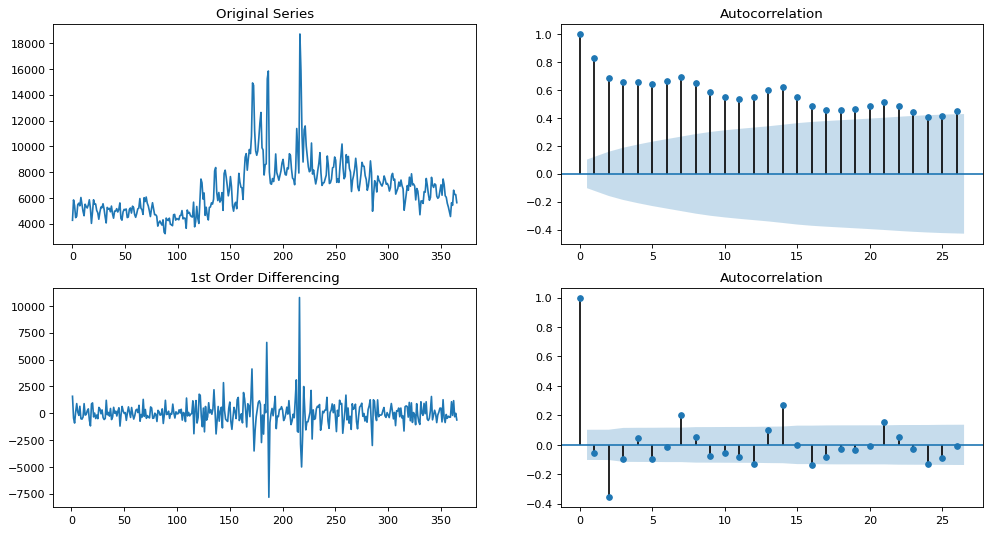

p-value: 0.000000
CPU times: user 767 ms, sys: 181 ms, total: 948 ms
Wall time: 798 ms


In [ ]:
%%time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':80})

# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(dfLine2.month); axes[0, 0].set_title('Original Series')
plot_acf(dfLine2.month, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(dfLine2.month.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(dfLine2.month.diff().dropna(), ax=axes[1, 1])

plt.show()

result = adfuller(dfLine2.month.diff().dropna())
print('p-value: %f' % result[1])

1st level differencing achieves a p-value of 0, and an autocorrelation graph that stays relatively within the boundries. HOWEVER, we can see that every 7 lags goes outside of the boundry, showing a weekly seasonality in the data. We need to implement SARIMAX to take care of that.

In [ ]:
%%time
from statsmodels.tsa.arima_model import ARIMA
#warnings for outdated ARIMA model, but we need this version to match what we have
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#automatic ARIMA model to find optimal hyperparameters for SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(dfLine, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p of 2
                      m=7,              # Weekly seasonality, so set 7 here
                      seasonal=True,    # Weekly seasonality, so set true
                      d = None,         # Let model determine the differencing with auto-regression and moving average being tuned
                      start_P=0,        # start seasonal p at 0
                      seasonal_test = 'ocsb',  # allow model to determine if the data is seasonal and fit the D based on this test
                      D = None,              # Weekly seasonality, so set None here to allow model to auto determine best value
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=6155.691, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=6220.655, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=6209.024, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6210.086, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6218.660, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=6165.483, Time=0.39 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=6133.232, Time=1.37 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=6150.153, Time=0.93 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=6143.462, Time=2.09 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=6138.945, Time=2.63 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=6138.612, Time=2.06 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=6134.540, Time=1.78 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=6143.323, Time=2.90 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=6180.426, Time=1.09 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept

We are told a model of SARIMAX(3,1,1)(1,0,1)[7] is best, so lets throw that into the model and look at some visualizations.

3,1,1 makes sense with our first visualizations because 3 p (AR) fits with spike we see in the autocorrelaltion plot of the 1'st level differencing, 1 I (d) gave us a p-score of 0, and 1 MA (q) would take more visualizations but fits with the understanding that recent events matter more for the data. (1,0,1,7) is the calculated ARIMA hyperparameters p,d,q for the season of 7 days.

(The hyperparameters chosen have changed between runtimes before, if this shows a different result for optimal for your runtime, know that the model has the above hyperparameters hard coded for the next cells)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Figure(800x560)
CPU times: user 2.16 s, sys: 1.56 s, total: 3.73 s
Wall time: 1.99 s


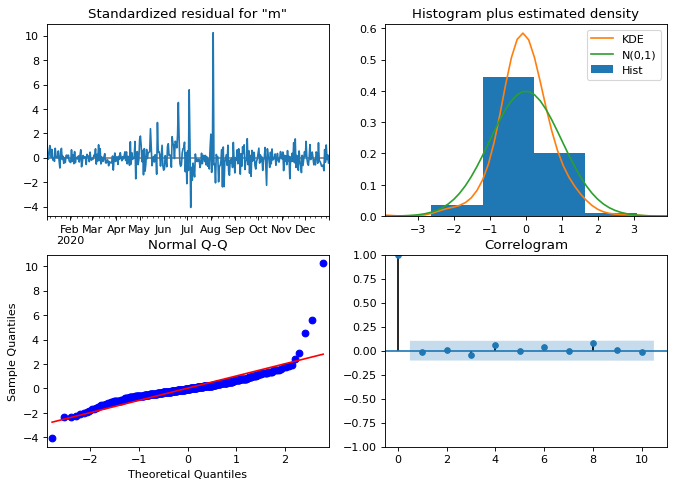

In [ ]:
%%time
#use suggested model, but use MA of 2 instead of 3
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(dfLine, order=(3,1,1), seasonal_order = (1,0,1,7)).fit()

print(model.plot_diagnostics(figsize=(10,7)))

Not perfect, but the spike from the storm seems to be throwing off some of our values still, as shown with a 'heavy tail' q-q plot. The correlation is doing well however.

Time to forecast

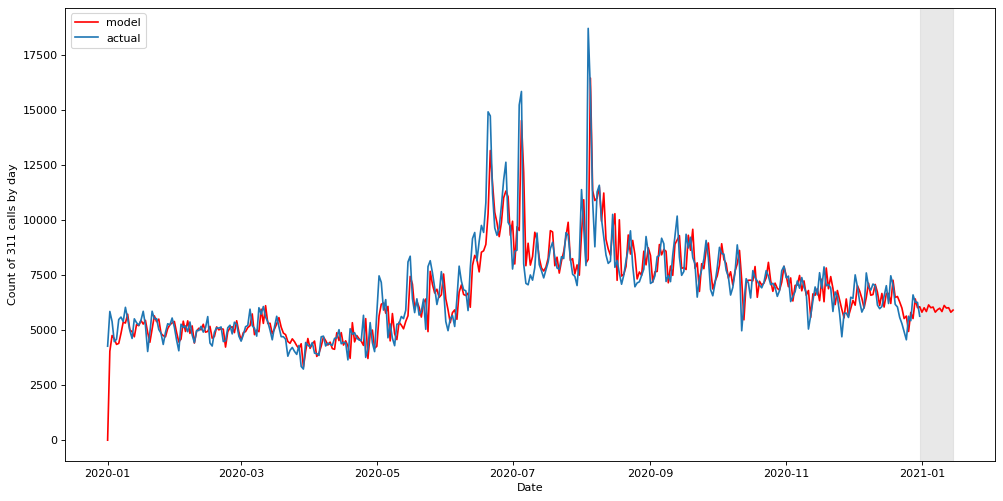

CPU times: user 301 ms, sys: 110 ms, total: 411 ms
Wall time: 294 ms


In [ ]:
%%time
#values from model to be graphed
testdata = model.fittedvalues

#forecast the next 2 weeks
forecast = model.predict(start=testdata.shape[0], end=testdata.shape[0] + 14)
forecast = testdata.append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(testdata.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(dfLine, label='actual')
plt.xlabel("Date")
plt.ylabel("Count of 311 calls by day")
plt.legend()
plt.show()

Lets calculate the RMSE of these 2 lines, but before that, we need to deal with the NaN values at the start of forecast programatically.

In [ ]:
%%time
#calculate shape
pre = forecast.shape[0]
#drop the leading nulls
forecast = forecast.dropna()
#shape after drop
post = forecast.shape[0]
#difference the 2
diff = post - pre

CPU times: user 537 µs, sys: 0 ns, total: 537 µs
Wall time: 548 µs


In [ ]:
%%time
from math import sqrt
from sklearn.metrics import mean_squared_error

#root mean square error of the 2 lines
rmse = sqrt(mean_squared_error(forecast[diff:dfLine.shape[0]],dfLine[diff:]))
print('RMSE is:', rmse)

from sklearn.metrics import r2_score

#r2 of the 2 lines, closer we are to 1 the better.
r2 = r2_score(forecast[diff:dfLine.shape[0]],dfLine[diff:])
print('R2 Score is:', r2)

RMSE is: 1050.8496312851378
R2 Score is: 0.7091524849462332
CPU times: user 2.61 ms, sys: 994 µs, total: 3.6 ms
Wall time: 3.71 ms


R2 of 0.711 is fairly high, especially for a forecast. This score is a model trained on itself though, the red piece with a grey bar is a forecast for no data

# Additional Models



### **Decision Tree**
We use a decision tree to predict time it takes to close a ticket (date_diff) by agency, complaint type, and borough

In [ ]:
# df1 = df.copy()

In [ ]:
%%time
#import libraries 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

CPU times: user 23.1 ms, sys: 9.6 ms, total: 32.7 ms
Wall time: 103 ms


Below is our idea for one hot encoding that crashed the runtime and ultimately did not work. Ran out of memory quickly

In [ ]:
# #one hot encoding for strings using dummies
# dfOHE = df1[['agency', 'complaint_type', 'borough', 'date_diff_sec']].copy()

# dfOHE = dfOHE.reset_index(drop=True)

# cat_val = ['agency', 'complaint_type', 'borough']

# for ins in cat_val:
#   #remove data that isn't frequent (below 1%) so session doesn't crash
#   value_counts = dfOHE[ins].value_counts()
#   to_remove = value_counts[value_counts <= (len(dfOHE.index) * .01)].index 
#   dfOHE.drop(dfOHE[dfOHE[ins].isin(to_remove)].index, inplace = True)

# for ins in cat_val:
#   #create temp list
#   temp_list = dfOHE[ins].tolist()
#   #temp dataframe to hold values from columns in loop
#   temp_df = pd.DataFrame(temp_list, columns = [ins])

#   # generate binary values using get_dummies
#   dum_df = pd.get_dummies(temp_df, columns=[ins], prefix=[ins] )
#   print(dum_df.shape)
#   # merge with main dataframe
#   dfOHE = dfOHE.join(dum_df)

# dfOHE = dfOHE.drop(cat_val, axis=1)
# dfOHE.head(10)

In [ ]:
%%time
# X values, what are we using to predict?
X = df1[['agency', 'complaint_type', 'borough']].copy()

le = preprocessing.LabelEncoder()
X_enc = X.apply(le.fit_transform)

#Y values, what are we trying to predict?
y = df1['date_diff_sec']

#80 20 split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=1)

CPU times: user 2.93 s, sys: 40.4 ms, total: 2.97 s
Wall time: 2.98 s


Lets try decision tree regression with a depth of 4

In [ ]:
%%time
from sklearn.metrics import r2_score
clf_DT = DecisionTreeRegressor(max_depth = 4)

clf_DT.fit(X_train, y_train)

y_pred_DT = clf_DT.predict(X_test)

print("r2 score:",r2_score(y_test, y_pred_DT))

r2 score: 0.1474971438261864
CPU times: user 1.31 s, sys: 9.04 ms, total: 1.32 s
Wall time: 1.31 s


r2 score of 0.15 is fairly low, lets plot the tree to see what the data is splitting on

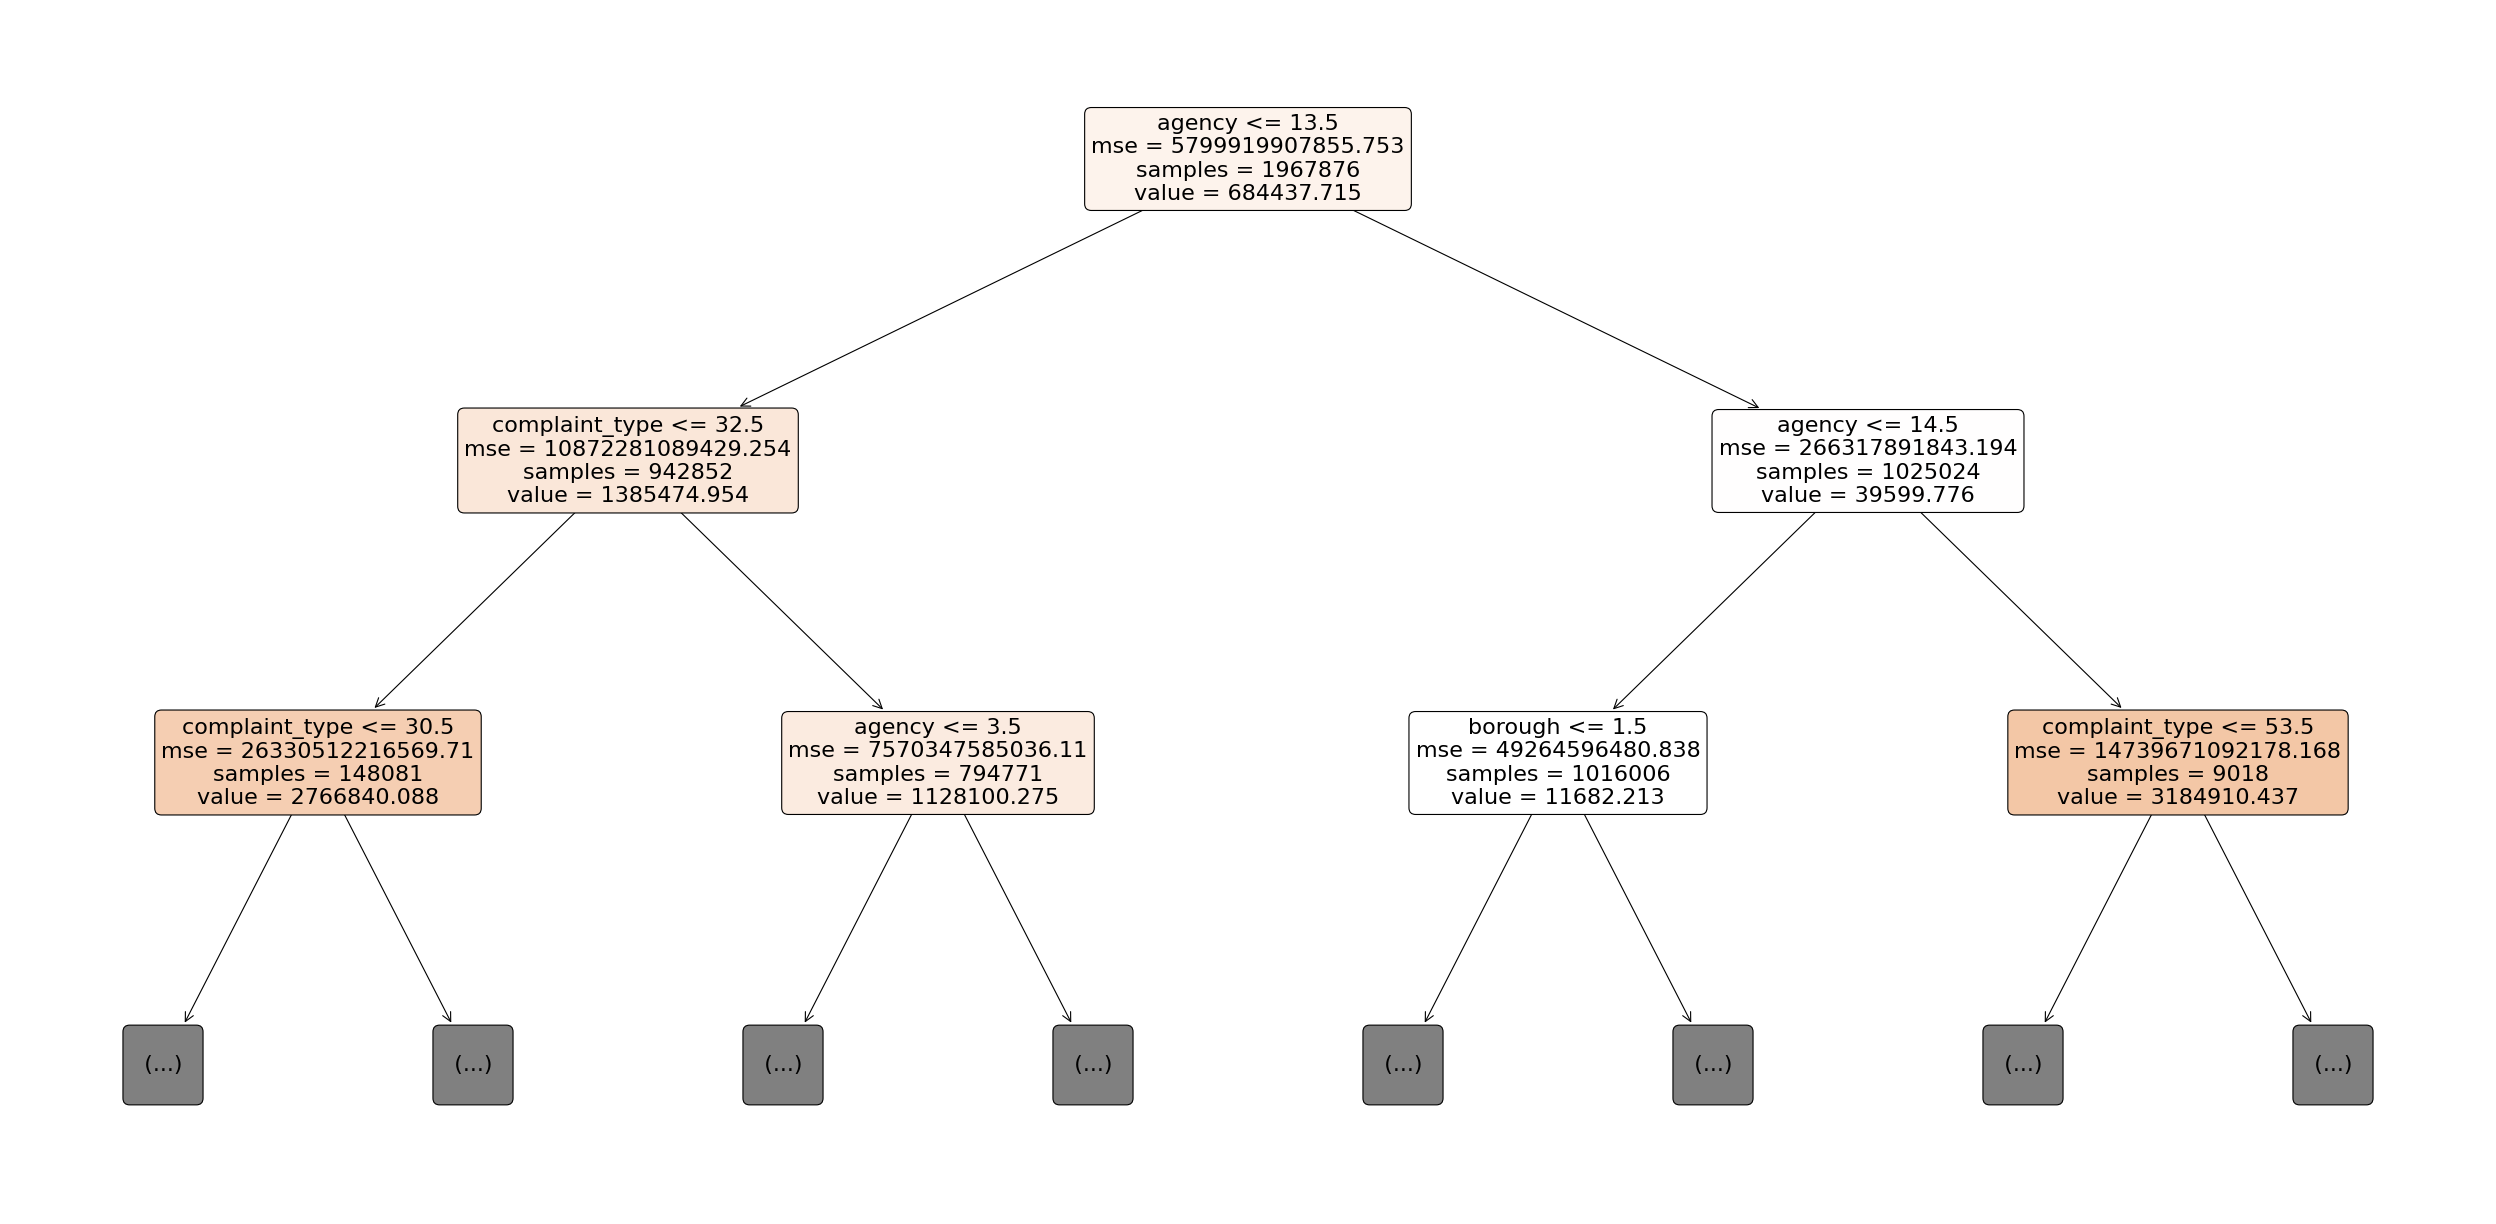

CPU times: user 900 ms, sys: 11.4 ms, total: 912 ms
Wall time: 910 ms


In [ ]:
%%time
# show decsion tree along with features 
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(40,20))  
tree.plot_tree(clf_DT, feature_names = X_train.columns, 
             filled=True, fontsize=20, rounded = True, max_depth = 2)
plt.show()

We can understand what the data is splitting on (numerical data due to label encoding), but the mse is ridiculously high. This model does not mean much

### **Random Forest**

In [ ]:
%%time
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Create a Gaussian Classifier
rf=RandomForestRegressor(n_estimators=10, max_depth = 3)

rf.fit(X_train,y_train)

y_RF_pred=rf.predict(X_test)

print("r2 score:",r2_score(y_test, y_pred_DT))

r2 score: 0.1474971438261864
CPU times: user 8.05 s, sys: 84.2 ms, total: 8.13 s
Wall time: 8.2 s


Random Forest didn't do better, but not many other models exist that would give us an adequate runtime with the large volume of data we have

In [ ]:
# from sklearn import svm
# from sklearn.svm import SVC
# clf_SVC = svm.SVC(kernel='rbf')

# clf_SVC.fit(X_train,y_train)

# y_SVC_pred=clf_SVC.predict(X_test)

# print("Accuracy:",metrics.accuracy_score(y_test, y_SVC_pred))

SVM also took too long and crashed the runtime. We tried a lot of different hyperparameters but the runtime would always either time out or run out of memory

# Conclusion


We found that the ARIMA model had the best performance at predicting call volume with an R2 value of 0.71. However, the random forest and the decsion tree models were not effective in prediciting the time until the complaints were closed with R2 values of 0.149 and 0.148 respectively.  

 Overall, this data does not lend itself to modeling due to the nature of 311 calls. We found that the data is unpredictable and that stochastic events influence call volume which in turn may impact response time. Examples of these events we found include extreme weather (Tropical storm Isaias), pandemic conditions, utility outages, and protests. Furthermore, the features that we selected did not appear to have much predictive value despite the fact that many complaint types were handled exclusively by one or two departments. 

To expand on this for future research, additional datasets could be integrated to model potential stochastic events and how these impact call volumes. For example, the integration of weather pattern data could assist in tagging calls in response to extreme weather. 